# Свёрточные сети

Пришло время собрать нашу первую свёрточную нейросеть. Будем использовать для этого датасет [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) (Canadian Institute for Advanced Research). Он включает в себя картинки из 10 разных классов: самолёты, машины, птицы, кошки, олени, собаки, лягушки, лошади, корабли, грузовики.   

<img src="http://www.pvsm.ru/images/2016/11/18/optimizaciya-neirosetevoi-platformy-Caffe-dlya-arhitektury-Intel-3.png" style="width:50%">

Всего $60 000$ цветных картинок размера $32 \times 32$. В каждом из классов ровно по $6000$ картинок.  Есть расширение этого датасета, CIFAR_100. Думаю, что по названию вы догадались, что в нём сто видов картинок. Кстати говоря, если очень хочется, можете принять участие [в стареньком соревновании на Kagle,](https://www.kaggle.com/c/cifar-10) связанным с этим датасетом. Там же на форуме можно найти интересный код для его решения.

In [1]:
import numpy as np
import random

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Sequential

tf.__version__ 

'2.7.0'

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", X_train.shape, y_train.shape)
print("Test samples:", X_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


Нарисуем несколько рандомных картинок из тренировочной выборки. 

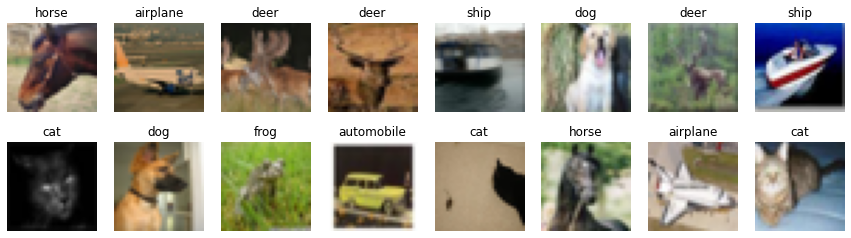

In [4]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

In [5]:
# Нормализация пикселей на отрезок [-1; 1]
X_train_n, X_test_n = X_train / 127.5 - 1, X_test / 127.5 - 1

In [6]:
X_train_n.max(), X_train_n.min()

(1.0, -1.0)

# 1. Полносвязная сеть

## 1.1 Обучение модели

Соберите полносвязную сеть из 5 слоёв с $256$, $128$, $64$, $32$, $10$ нейронами. На последнем слое используйте в качестве активации `softmax`. На всех промежуточных `relu`.

In [7]:
model_fc = Sequential()

model_fc.add(layers.Flatten(input_shape=(32, 32, 3)))

for unit in [256, 128, 64, 32]:
    model_fc.add(layers.Dense(unit, activation='relu'))

model_fc.add(layers.Dense(10, activation='softmax'))

In [8]:
model_fc(X_train[:2])

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[2.4789031e-06, 0.0000000e+00, 0.0000000e+00, 4.0351939e-24,
        0.0000000e+00, 0.0000000e+00, 1.3664667e-34, 0.0000000e+00,
        9.9999750e-01, 0.0000000e+00],
       [4.5992095e-19, 5.5353733e-37, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        4.9239929e-08, 0.0000000e+00]], dtype=float32)>

Обучите получившуюся модель на __нормализованной__ выборке.

In [9]:
# model_fc = FCmodel()

model_fc.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history_fc = model_fc.fit(
    X_train_n, y_train,
    batch_size = 32,
    epochs = 10,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
1407/1407 [==============================] - 13s 9ms/step - loss: 1.7471 - accuracy: 0.3777 - val_loss: 1.6308 - val_accuracy: 0.4248
Epoch 2/10
1407/1407 [==============================] - 12s 9ms/step - loss: 1.5465 - accuracy: 0.4488 - val_loss: 1.5289 - val_accuracy: 0.4644
Epoch 3/10
1407/1407 [==============================] - 12s 9ms/step - loss: 1.4406 - accuracy: 0.4890 - val_loss: 1.4794 - val_accuracy: 0.4726
Epoch 4/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.3583 - accuracy: 0.5180 - val_loss: 1.4360 - val_accuracy: 0.4888
Epoch 5/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.2841 - accuracy: 0.5448 - val_loss: 1.4419 - val_accuracy: 0.4890
Epoch 6/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.2214 - accuracy: 0.5651 - val_loss: 1.4108 - val_accuracy: 0.5058
Epoch 7/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.1642 - accuracy: 0.5879 - val_loss: 1.3915 - val_ac

In [10]:
model_fc.evaluate(X_test,  y_test, verbose=2)

313/313 - 1s - loss: 265.4119 - accuracy: 0.2793 - 1s/epoch - 4ms/step


[265.4118957519531, 0.2793000042438507]

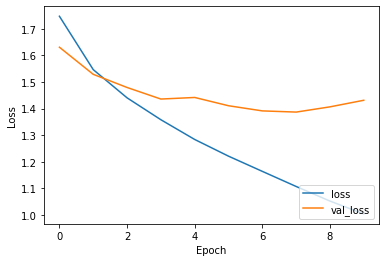

In [11]:
plt.plot(history_fc.history['loss'], label='loss')
plt.plot(history_fc.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right');

__Упражнение:__ Объясните зачем нужно нормализовывать картинки. 

## 1.2 Ошибки модели

Посмотрим на примеры картинок, где ошибалась наша модель. 

In [12]:
y_pred = np.argmax(model_fc.predict(X_test), axis=1)
errors =  y_pred != y_test.T[0]
errors[:5]

array([False, False, False, False,  True])

In [13]:
X_err = X_test[errors]
y_err = y_test[errors].T[0]
y_pred = y_pred[errors]

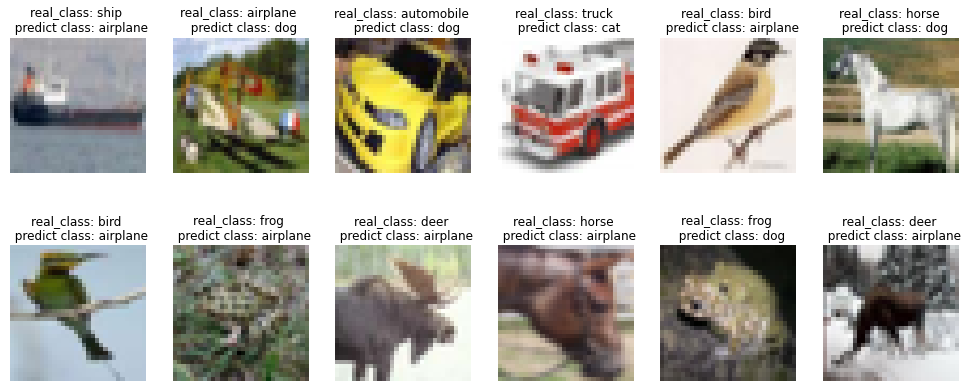

In [14]:
cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(cifar10_classes[y_err[random_index]], 
                                                                   cifar10_classes[y_pred[random_index]]))
plt.show()

Посмотрим на то, путает ли модель систематически одни классы с другими. Например, лошадей с оленями.  Чтобы лучше было видно занулите диагональ у `confusion_matrix`. 

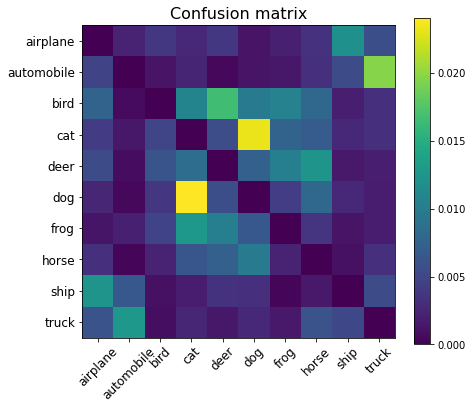

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score

p_pred = model_fc.predict(X_test_n)
y_pred = np.argmax(p_pred, axis=1)

cm = confusion_matrix(y_test.T[0], y_pred, normalize='all')
cm = cm - np.eye(NUM_CLASSES)*cm.diagonal()

plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(cm)
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar();

# 2. Свёрточная сеть

## 2.1 Обучение модели

Соберите следующую свёрточную нейронную сетку:

- Свёрточный слой с 16 выходными каналами и ядром 3х3. Поставьте опцию `padding='same'` для дополнения нулями и шаг для свёртки (stride) размера (2,1)
- Max pooling с ядром 2х2
- Свёрточный слой с 32 выходными каналами и ядром 3х3 Поставьте опцию `padding='same'` для дополнения нулями. 
- Avg pooling с ядром 2х2
- Свёрточный слой с 64 выходными каналами и ядром 3х3. Поставьте опцию `padding='same'` для дополнения нулями.
- Max pooling с ядром 2х2

- Полносвязыный слой со 128 выходами
- Полносвязыный слой с 64 выходами
- Полносвязыный слой с 10 выходами

После каждого свёрточного и полносвзяного слоя (кроме последнего) будем использовать функцию активации ReLU.

In [16]:
model_cnn = Sequential([
    layers.Conv2D(16, kernel_size=(3,3), 
                padding='same', strides=(2,1),
                activation='relu',
                input_shape=(32, 32, 3)),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Conv2D(32, kernel_size=(3,3), 
                padding='same', activation='relu'),
    layers.AvgPool2D(pool_size=(2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), 
                padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', name='fc_embedding_128'),
    layers.Dense(64, activation='relu', name='fc_embedding_64'),
    layers.Dense(10, activation='softmax')
])

In [17]:
model_cnn(X_train_n[:2])

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0.10786337, 0.09630898, 0.09528811, 0.09968624, 0.09411527,
        0.10271582, 0.10141611, 0.09884996, 0.10216354, 0.10159256],
       [0.11366951, 0.09381758, 0.09378228, 0.09731296, 0.09014794,
        0.10192999, 0.10539229, 0.09455919, 0.10593461, 0.10345359]],
      dtype=float32)>

Обучите получившуюся модель. 

In [18]:
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history_cnn = model_cnn.fit(
    X_train_n, y_train,
    batch_size = 32,
    epochs = 10,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
1407/1407 [==============================] - 30s 21ms/step - loss: 1.4910 - accuracy: 0.4545 - val_loss: 1.2039 - val_accuracy: 0.5672
Epoch 2/10
1407/1407 [==============================] - 29s 20ms/step - loss: 1.1275 - accuracy: 0.5978 - val_loss: 1.0649 - val_accuracy: 0.6314
Epoch 3/10
1407/1407 [==============================] - 29s 21ms/step - loss: 0.9690 - accuracy: 0.6573 - val_loss: 0.9815 - val_accuracy: 0.6552
Epoch 4/10
1407/1407 [==============================] - 29s 21ms/step - loss: 0.8666 - accuracy: 0.6932 - val_loss: 0.9814 - val_accuracy: 0.6630
Epoch 5/10
1407/1407 [==============================] - 29s 21ms/step - loss: 0.7878 - accuracy: 0.7237 - val_loss: 0.8909 - val_accuracy: 0.6902
Epoch 6/10
1407/1407 [==============================] - 29s 21ms/step - loss: 0.7297 - accuracy: 0.7430 - val_loss: 0.8564 - val_accuracy: 0.7014
Epoch 7/10
1407/1407 [==============================] - 29s 21ms/step - loss: 0.6774 - accuracy: 0.7624 - val_loss: 0.8434 -

In [19]:
model_cnn.evaluate(X_test_n,  y_test, verbose=2)

313/313 - 2s - loss: 0.9142 - accuracy: 0.6964 - 2s/epoch - 7ms/step


[0.914151668548584, 0.696399986743927]

Посмотрим на то, как ошибка вела себя на обучении и валидации. 

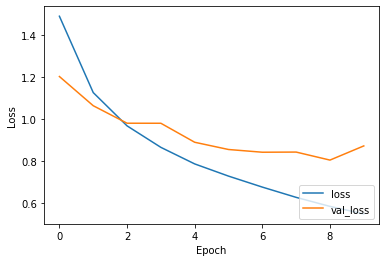

In [20]:
plt.plot(history_cnn.history['loss'], label='loss')
plt.plot(history_cnn.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right');

## 2.2  Ошибки модели

Снова посмотрим на примеры картинок, где ошибалась наша модель. 

In [21]:
p_pred = model_cnn.predict(X_test_n)
y_pred = np.argmax(p_pred, axis=1)
errors =  y_pred != y_test.T[0]

X_err = X_test[errors]
y_err = y_test[errors].T[0]
y_pred = y_pred[errors]
p_pred = p_pred[errors]

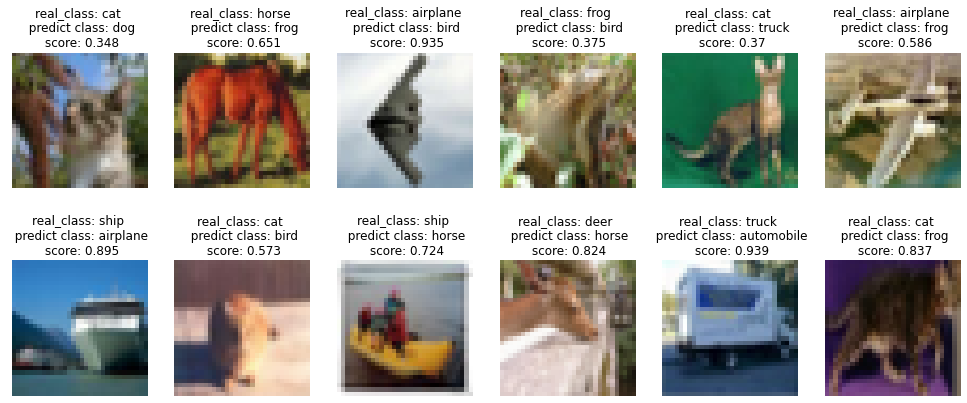

In [22]:
cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {} \n score: {:.3}'.format(cifar10_classes[y_err[random_index]], 
                                                                   cifar10_classes[y_pred[random_index]], np.max(p_pred[random_index])))
plt.show()

Посмотрим на то, путает ли модель систематически одни классы с другими. Например, лошадей с оленями. 

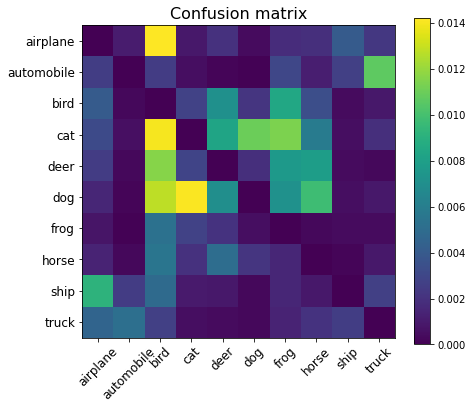

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

p_pred = model_cnn.predict(X_test_n)
y_pred = np.argmax(p_pred, axis=1)

cm = confusion_matrix(y_test.T[0], y_pred, normalize='all')
cm = cm - np.eye(NUM_CLASSES)*cm.diagonal()

plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(cm)
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar();

Подсчитайте число параметров, которое оценивалось в полносвязной модели и число параметров, которое оценивалось в свёрточной модели.

In [24]:
model_fc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 830,250
Trainable params: 830,250
Non-trai

In [25]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 16, 16)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 16, 32)         4640      
                                                                 
 average_pooling2d (AverageP  (None, 4, 8, 32)         0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 8, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 4, 64)        

In [26]:
np.sum([np.sum([np.prod(item.shape) for item in l.variables]) for l in model_fc.layers])

830250.0

In [27]:
np.sum([np.sum([np.prod(item.shape) for item in l.variables]) for l in model_cnn.layers])

98154.0

__Упражнение:__ Как именнов свёрточной сетке увеличивается поле восприятия? Правда ли, что к `Flatten()`- слою поле восприятия достигает размера картинки? Зачем нам нужно, чтобы это происходило? 

> __Если вам стало скучновато, попробуйте поэкспериментировать с размерами сетки и её архитектурой. Попытайтесь добиться максимально классных результатов.__  [При желании и хорошей регуляризации](https://www.kaggle.com/arianshf/cifar-10-classification-using-cnn) можно выбить Accuracy в районе $0.9,$ а то и выше. Также можете посмотреть, как [похожие архитектуры собрать в pytorch.](https://www.kaggle.com/xcwang21/cifar10-with-mlp-lenet-resnet-for-beginners)


### Различные трюки: 

1. Начните с маленькой сети. Не забывайте прикидывать сколько наблдюдений  тратится на оценку каждого из  параметров. Если величина очень маленькая, не забывайте о регуляризации.
2. Всегда оставляйте часть выборки под валидацию на каждой эпохе.
3. Усложняйте модель, пока качество на валидации не начнёт падать.
4. Не забывайте проскалировать ваши наблюдения для лучшей сходимости.
5. Можно попробовать ещё целую серию различных трюков:
  - Архитектура нейросети
    - Больше/меньше нейронов
    - Больше/меньше слоёв
    - Другие функции активации (tanh, relu, leaky relu, elu etc)
    - Регуляризация (dropout, l1,l2)
  - Более качественная оптимизация
    - Можно попробовать выбрать другой метод оптимизации
    - Можно попробовать менять скорость обучения, моментум и др.
    - Разные начальные значения весов
  - Попробовать собрать больше данных
  - Для случая картинок объёмы данных можно увеличить искусственно с помощью подхода, который называется Data augmemntation

И это далеко не полный список. Обратите внимание, что делать grid_search для больших сеток это довольно времязатратное занятие... 

Логгируйте свои эксперименты. За один прогон пробуйте одно изменение. Иначе будет непонятно какие именно изменения улучшили качество, а какие ухудшили. 

# 3. Эмбеддинги 

__«Эмбеддинг» (embedding – вложение)__ — это сопоставление произвольной сущности (например, узла в графе, текста или кусочка картинки) некоторому вектору.

На самом деле вcё глубокое обучение держится на идее эмбеддингов. Один из способов обучить эмбеддинг для картинок — обучить классификатор для какой-то сложной задачи, а затем срезать последние слои. Промежуточный слой будет выдавать вектор какого-то размера для каждой картинки. Эти вектора можно будет использовать в других своих задачах. 

Давайте вытащим представление картинок для тестовой выборки с одного из последних слоёв и построим для неё TSNE-визуализацию.

In [28]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 16, 16)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 16, 32)         4640      
                                                                 
 average_pooling2d (AverageP  (None, 4, 8, 32)         0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 8, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 4, 64)        

Достать из сетки любой слой можно по имени. Имена можно дать слоям при объявлении архитектуры. 

In [29]:
embed_layer = model_cnn.get_layer('fc_embedding_64')

У каждого слоя есть свои атрибуты: переменные, вход, выход и тп.

In [30]:
embed_layer.output

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'fc_embedding_64')>

In [31]:
embed_layer.variables

[<tf.Variable 'fc_embedding_64/kernel:0' shape=(128, 64) dtype=float32, numpy=
 array([[-0.33599812,  0.13373291, -0.2080173 , ..., -0.11381336,
         -0.30501583, -0.1945294 ],
        [-0.04891558, -0.00778341,  0.04509101, ..., -0.00154936,
          0.00136161,  0.03942632],
        [-0.04582222, -0.03539413,  0.00977104, ..., -0.03419064,
          0.1819867 , -0.06328626],
        ...,
        [-0.06615239, -0.15172239, -0.05151713, ..., -0.01198107,
         -0.24645619, -0.01921686],
        [-0.1167845 , -0.10347088,  0.09920631, ...,  0.28636044,
          0.19465508,  0.01981089],
        [-0.00904703,  0.04879686, -0.04768906, ...,  0.349013  ,
          0.03437598, -0.08242887]], dtype=float32)>,
 <tf.Variable 'fc_embedding_64/bias:0' shape=(64,) dtype=float32, numpy=
 array([-0.01796873, -0.08937194,  0.0711247 ,  0.20608646,  0.08804239,
         0.21325117, -0.03613658, -0.05352916,  0.15591176, -0.04382535,
         0.12434004,  0.1495764 , -0.09724136, -0.03718476,

Нас интересует выход из слоя. Мы хотим собрать новую модель. Она должна принимать на вход картинку и выплёвывать выход из конкретного слоя. Это можно сделать с помощью класса `Model`. В нём нужно перечислить входы и выходы. 

In [32]:
feature_extractor = Model(
    inputs=model_cnn.input,
    outputs=embed_layer.output
)

Прогоним новую модель на какой-нибудь картинке. 

In [33]:
feature_extractor(X_test_n[:1])

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 1.412777  , 0.        ,
        0.        , 2.153353  , 0.        , 0.        , 0.79228556,
        0.        , 0.        , 0.        , 0.        , 0.19896352,
        0.        , 0.4466002 , 1.7903798 , 0.        , 0.8205217 ,
        1.2134742 , 0.        , 1.8394352 , 2.4205863 , 0.        ,
        0.        , 0.        , 0.        , 1.8705599 , 1.1994656 ,
        0.        , 2.3608139 , 0.        , 0.18136007, 0.7568178 ,
        0.        , 0.        , 0.        , 0.11192022, 2.0876265 ,
        0.        , 2.0144198 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.8285435 , 0.96920127, 0.75345445, 0.        , 0.065781  ,
        1.2890267 , 1.1979924 , 1.9494492 , 1.7438159 , 0.        ,
        1.3188607 , 0.15235007, 0.        , 0.52790594]], dtype=float32)>

На вход пришла картинка, на выходе получился вектор, который её описывает. 

__Упражнение:__ ReLU-активация занулила на этом слое часть выходов. Как думаете, как это скажется на качестве эмбеддинга?  

In [34]:
X_emb = feature_extractor(X_test_n)
X_emb.shape

TensorShape([10000, 64])

Визуализируем данные с помощью TSNE. Вы знаете этот метод визуализации данных из курса по машинному обучению. Если подзабыли как он работает, почитайте [статью на DistillPub.](https://distill.pub/2016/misread-tsne/) Внутри sklearn есть реализация TSNE, но она не такая эффективная как [библиотека MulticoreTSNE,](https://github.com/DmitryUlyanov/Multicore-TSNE) в которой метод можно распараллелить.

In [35]:
!pip install MulticoreTSNE

In [36]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=4, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_emb)

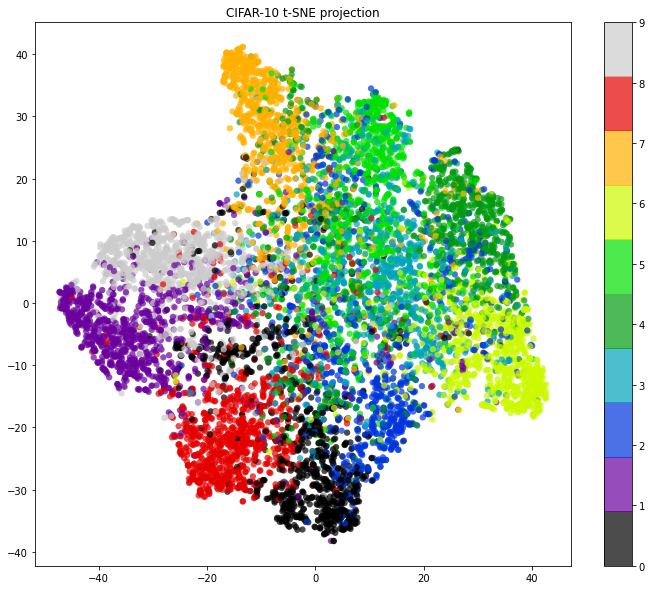

In [41]:
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test.T[0], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('CIFAR-10 t-SNE projection');

In [38]:
cifar10_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Видно, что эмбеддинги впитали в себя информацию о том, к какому классу относится какая картинка. В больших технологических компаниях с картинками часто работают следующим образом. 

- Каким-то методом учат огромную нейросеть, которая хорошо понимает что изображено на картинках. Такую большую сетку называют __тушей__ или __тушкой.__
- Берут эмбеддинги с одного из последних слоёв и доучивают на них маленькие модели. Например, модели для классификации. Их называют __головами.__ 
- Эмбеддинги картинок посылают на вход другим моделям. Например, в градиентный бустинг. Обычно фичи, полученные из нейросети называют __нейросетевыми фичами.__ 

Конечно же это не единственный способ получать для картинок эмбеддинги. Дальше мы будем обсуждать и другие методы. 


 # 4. Стреляем себе в ногу
 
Давайте разберём несколько архитектур. Попытайтесь понять что именно с ними не так. Упражнения позаимствованы [из нескольких ШАДОвских семинаров.](https://github.com/yandexdataschool/Practical_DL/blob/master/week03_convnets/other_frameworks/how_to_shoot_yourself_in_the_foot_with_cnn.ipynb)

#### a) Задача регрессии. Предсказываем цены на недвижимость.

In [39]:
model = Sequential()
model.add(InputLayer([39]))
model.add(BatchNormalization())
model.add(Dense(128, kernel_initializer=keras.initializers.zeros()))
model.add(Dense(128, kernel_initializer=keras.initializers.zeros()))
model.add(Dense(1))

model.compile(optimizer='sgd', loss='mean_squared_error')

####  б) Классификация картинок, например, fashion MNIST

In [39]:
model = Sequential()

model.add(InputLayer([28, 28, 1]))
model.add(Conv2D(filters=512, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('softmax'))
model.add(Dropout(0.1))
model.add(Dense(10))
model.add(Activation('softmax'))
model.add(Dropout(0.1))

model.compile(optimizer='rmsprop', loss='mean_squared_error')

#### в) И снова fashion MNIST, но теперь мы знаем, что размер картинки $100 \times 100$ пикселей

Если попробовать скомпилировать эту сетку, вылезет ошибка.

In [39]:
model = Sequential()
model.add(InputLayer([100, 100, 3]))

for filters in [32, 64, 128, 256]:
    model.add(Conv2D(filters, kernel_size=(5, 5)))
    model.add(Conv2D(filters, kernel_size=(1, 1)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_accuracy')